<a href="https://colab.research.google.com/github/MohamedRefaat92/Deep-learning-practice-claude/blob/main/Genomics/session-3/session_03_neural_networks_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3: Building Neural Networks with nn.Module
## Complete Guide to Deep Learning Architectures for Genomics

**📖 Book References**:
- Deep Learning with PyTorch Ch. 6 (pages 175-220)
- Learn Generative AI with PyTorch Ch. 2, Appendix B

**⏱️ Duration**: 3-4 hours  
**🎯 Difficulty**: Beginner-Intermediate

---

## 🎯 Learning Objectives & Core Functions

### What You'll Learn:
✅ Build custom models with `nn.Module`  
✅ Implement forward passes  
✅ Use activation functions effectively  
✅ Apply regularization (dropout, batch norm)  
✅ Build genomics classifiers  
✅ Initialize weights properly

### Core PyTorch Functions:

In [ ]:
nn.Module              # Base class
nn.Linear()            # Fully connected layer
nn.ReLU()              # Activation
nn.Dropout()           # Regularization
nn.BatchNorm1d()       # Normalization
nn.Sequential()        # Container
model.parameters()     # Get parameters
model.train()          # Training mode
model.eval()           # Evaluation mode

---

## 📚 Quick Theory

### The nn.Module Pattern:

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()        # MUST call this!
        self.layer1 = nn.Linear(10, 20)
        self.layer2 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

**Key Points**:
- `__init__`: Define layers
- `forward`: Define computation
- Don't call `forward()` directly, use `model(x)`
- `super().__init__()` is REQUIRED

---

## 🧪 Exercise 1: Basic Neural Network

### Task: Build 2-layer network for gene expression prediction

In [43]:
class SimpleMLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = nn.ReLU(self.fc1(x))
    x = self.fc2(x)
    return x

model = SimpleMLP(input_size=3, hidden_size=10, output_size=1)
print(f"\nModel:\n{model}")
total_params = [p.numel() for p in model.parameters()]




Model:
SimpleMLP(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


[30, 10, 10, 1]

Features shape: torch.Size([200, 3])
Labels shape: torch.Size([200])
\nModel:\nSimpleMLP(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
\nTotal parameters: 51
Epoch 20: Loss = 0.2095
Epoch 40: Loss = 0.0435
Epoch 60: Loss = 0.0102
Epoch 80: Loss = 0.0086
Epoch 100: Loss = 0.0084
\nFinal MSE: 0.0084


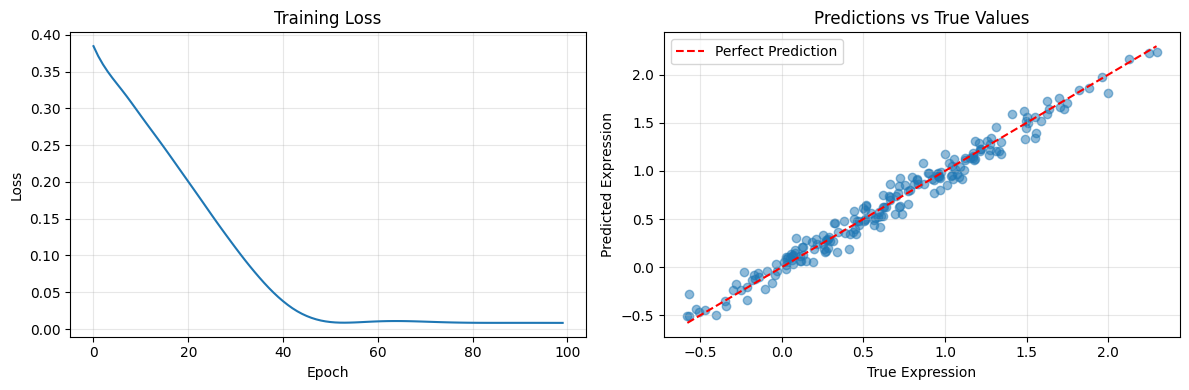

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate data
torch.manual_seed(42)
n_samples = 200
tf_binding = torch.rand(n_samples, 3)  # 3 TF binding scores
gene_expression = (tf_binding[:, 0] * 2 +
                   tf_binding[:, 1] * -1 +
                   tf_binding[:, 2] * 0.5 +
                   torch.randn(n_samples) * 0.1)

#A more succinct and intuitive way to define the gene expression matrix
##tf_scales = torch.tensor([2,-1,0.5])
##gene_expression = (tf_binding*tf_scales).sum(dim = 1)
##expression_noise = torch.randn(n_samples) * 0.1
##gene_expression += expression_noise

print(f"Features shape: {tf_binding.shape}")
print(f"Labels shape: {gene_expression.shape}")

# Simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create and inspect model
model = SimpleMLP(input_size=3, hidden_size=10, output_size=1)
print(f"\\nModel:\\n{model}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\\nTotal parameters: {total_params}")

#a common mistake is to use len(p) instead of p.numel().
#len(p) gives the number of elements in the first dimension of the parameter tensor.
#p.numel() gives the total number of elements in each paramter tensor.

# Training function
def train(model, X, y, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        # Forward
        y_pred = model(X).squeeze()
        loss = criterion(y_pred, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

    return losses

# Train
losses = train(model, tf_binding, gene_expression, epochs=100)

# Evaluate
model.eval()
with torch.no_grad():
    predictions = model(tf_binding).squeeze()
    mse = F.mse_loss(predictions, gene_expression)
    print(f"\\nFinal MSE: {mse.item():.4f}")

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(gene_expression, predictions, alpha=0.5)
plt.plot([gene_expression.min(), gene_expression.max()],
         [gene_expression.min(), gene_expression.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('Predictions vs True Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 🧪 Exercise 2: Promoter Sequence Classifier

### Task: Classify DNA sequences as promoters or non-promoters

In [ ]:
def encode_sequence(seq):
    \"\"\"One-hot encode DNA sequence.\"\"\"
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0],
               'G': [0,0,1,0], 'T': [0,0,0,1]}
    encoded = [mapping.get(base, [0,0,0,0]) for base in seq.upper()]
    return torch.tensor(encoded, dtype=torch.float32).flatten()

# Generate synthetic promoter data
def generate_promoter_data(n_samples=500):
    promoters = []
    non_promoters = []

    # Promoter motif: TATA box
    for _ in range(n_samples // 2):
        # Promoters have TATA box
        seq = 'TATAAAA' + ''.join(np.random.choice(['A','C','G','T'], 43))
        promoters.append((seq, 1))

        # Non-promoters don't
        seq = ''.join(np.random.choice(['A','C','G','T'], 50))
        non_promoters.append((seq, 0))

    data = promoters + non_promoters
    np.random.shuffle(data)

    sequences, labels = zip(*data)
    X = torch.stack([encode_sequence(s) for s in sequences])
    y = torch.tensor(labels, dtype=torch.float32)

    return X, y

# Generate data
import numpy as np
X, y = generate_promoter_data(n_samples=500)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Split data
n_train = 400
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

# Build classifier
class PromoterClassifier(nn.Module):
    def __init__(self, input_size=200, hidden_sizes=[128, 64], dropout=0.2):
        super().__init__()

        # Build layers
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_size = hidden_size

        layers.append(nn.Linear(in_size, 1))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()

# Create model
model = PromoterClassifier(input_size=200, hidden_sizes=[128, 64], dropout=0.3)
print(f"Model:\\n{model}\\n")

# Training with validation
def train_with_validation(model, X_train, y_train, X_val, y_val,
                          epochs=100, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_acc = ((y_pred > 0.5) == y_train).float().mean()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)
            val_acc = ((y_val_pred > 0.5) == y_val).float().mean()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accs.append(train_acc.item())
        val_accs.append(val_acc.item())

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: "
                  f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Train
results = train_with_validation(model, X_train, y_train, X_val, y_val, epochs=100)
train_losses, val_losses, train_accs, val_accs = results

# Visualize
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train')
ax2.plot(val_accs, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion matrix on validation
model.eval()
with torch.no_grad():
    y_pred = (model(X_val) > 0.5).long()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
ax3.imshow(cm, cmap='Blues')
ax3.set_title('Confusion Matrix (Validation)')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
for i in range(2):
    for j in range(2):
        ax3.text(j, i, cm[i,j], ha='center', va='center')

# ROC curve
from sklearn.metrics import roc_curve, auc
with torch.no_grad():
    y_scores = model(X_val).numpy()

fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)
ax4.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
ax4.plot([0, 1], [0, 1], 'k--')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\nFinal Validation Accuracy: {val_accs[-1]:.4f}")
print(f"Final Validation AUC: {roc_auc:.4f}")

---

## 🧪 Exercise 3: Activation Functions Comparison

### Task: Compare different activation functions

In [ ]:
class MLPWithActivation(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        self.fc1 = nn.Linear(3, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        self.activation_name = activation

        # Select activation
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'leaky_relu':
            self.activation = F.leaky_relu
        else:
            raise ValueError(f"Unknown activation: {activation}")

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Generate nonlinear data
torch.manual_seed(42)
X = torch.rand(300, 3)
y = torch.sin(X[:,0] * 3) + torch.cos(X[:,1] * 2) + torch.randn(300) * 0.1

# Compare activations
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu']
results = {}

for act in activations:
    print(f"\\nTraining with {act}...")
    model = MLPWithActivation(activation=act)
    losses = train(model, X, y, epochs=100, lr=0.01)
    results[act] = losses

# Plot comparison
plt.figure(figsize=(10, 6))
for act, losses in results.items():
    plt.plot(losses, label=act, alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Activation Function Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

---

## 🧪 Exercise 4: Batch Normalization

### Task: Understand batch normalization benefits

In [ ]:
class MLPWithBatchNorm(nn.Module):
    def __init__(self, use_bn=True):
        super().__init__()
        self.fc1 = nn.Linear(10, 50)
        self.bn1 = nn.BatchNorm1d(50) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(50, 30)
        self.bn2 = nn.BatchNorm1d(30) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(30, 1)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Generate data
torch.manual_seed(42)
X = torch.randn(500, 10) * 5  # Large scale variation
y = (X.sum(dim=1) + torch.randn(500) * 2)

# Compare with and without BN
models = {
    'Without BatchNorm': MLPWithBatchNorm(use_bn=False),
    'With BatchNorm': MLPWithBatchNorm(use_bn=True)
}

results_bn = {}
for name, model in models.items():
    print(f"\\n{name}:")
    losses = train(model, X, y, epochs=100, lr=0.01)
    results_bn[name] = losses

# Plot
plt.figure(figsize=(10, 6))
for name, losses in results_bn.items():
    plt.plot(losses, label=name, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Effect of Batch Normalization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 🧪 Exercise 5: Dropout Regularization

### Task: Prevent overfitting with dropout

In [ ]:
class DropoutMLP(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.fc1 = nn.Linear(5, 100)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Small dataset (prone to overfitting)
torch.manual_seed(42)
X_small = torch.randn(50, 5)
y_small = (X_small.sum(dim=1) + torch.randn(50) * 0.5)

X_val = torch.randn(100, 5)
y_val = (X_val.sum(dim=1) + torch.randn(100) * 0.5)

# Compare dropout rates
dropout_rates = [0.0, 0.2, 0.5]
dropout_results = {}

for rate in dropout_rates:
    print(f"\\nDropout rate: {rate}")
    model = DropoutMLP(dropout_rate=rate)
    train_losses, val_losses, _, _ = train_with_validation(
        model, X_small, y_small, X_val, y_val, epochs=200, lr=0.01
    )
    dropout_results[rate] = (train_losses, val_losses)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for rate, (train_losses, val_losses) in dropout_results.items():
    ax1.plot(train_losses, label=f'Dropout {rate}', alpha=0.7)
    ax2.plot(val_losses, label=f'Dropout {rate}', alpha=0.7)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss (Overfitting Check)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 🧪 Exercise 6: Weight Initialization

### Task: Understand importance of proper initialization

In [ ]:
class InitializedMLP(nn.Module):
    def __init__(self, init_method='default'):
        super().__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 1)

        # Initialize weights
        if init_method == 'zeros':
            self._init_zeros()
        elif init_method == 'xavier':
            self._init_xavier()
        elif init_method == 'kaiming':
            self._init_kaiming()
        # else: use PyTorch default

    def _init_zeros(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)
                nn.init.zeros_(m.bias)

    def _init_xavier(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def _init_kaiming(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Generate data
torch.manual_seed(42)
X = torch.randn(200, 10)
y = X.sum(dim=1) + torch.randn(200)

# Compare initialization methods
init_methods = ['default', 'xavier', 'kaiming']  # Skip 'zeros' - it won't learn!
init_results = {}

for method in init_methods:
    print(f"\\nInitialization: {method}")
    model = InitializedMLP(init_method=method)
    losses = train(model, X, y, epochs=100, lr=0.01)
    init_results[method] = losses

# Plot
plt.figure(figsize=(10, 6))
for method, losses in init_results.items():
    plt.plot(losses, label=method, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Effect of Weight Initialization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

---

## 🎯 Challenge 1: Multi-Task Learning

### Task: Predict both expression level AND tissue type

In [ ]:
class MultiTaskModel(nn.Module):
    \"\"\"
    Multi-task model for genomics:
    - Task 1: Predict gene expression (regression)
    - Task 2: Predict tissue type (classification)
    \"\"\"
    def __init__(self, input_size, hidden_size, n_tissues):
        super().__init__()

        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )

        # Task-specific heads
        self.expression_head = nn.Sequential(
            nn.Linear(hidden_size // 2, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

        self.tissue_head = nn.Sequential(
            nn.Linear(hidden_size // 2, 20),
            nn.ReLU(),
            nn.Linear(20, n_tissues)
        )

    def forward(self, x):
        shared_features = self.shared(x)
        expression = self.expression_head(shared_features)
        tissue_logits = self.tissue_head(shared_features)
        return expression.squeeze(), tissue_logits

# Generate multi-task data
torch.manual_seed(42)
n_samples = 500
n_features = 20
n_tissues = 3

X = torch.randn(n_samples, n_features)
tissue_types = torch.randint(0, n_tissues, (n_samples,))

# Expression depends on features and tissue
expression = X.sum(dim=1)
for i in range(n_tissues):
    mask = tissue_types == i
    expression[mask] += (i - 1) * 2  # Tissue effect

expression += torch.randn(n_samples) * 0.5

print(f"Data: {X.shape}")
print(f"Expression: {expression.shape}")
print(f"Tissues: {tissue_types.shape}")
print(f"Tissue distribution: {torch.bincount(tissue_types)}")

# Create model
model = MultiTaskModel(input_size=n_features, hidden_size=64, n_tissues=n_tissues)

# Multi-task training
def train_multitask(model, X, y_expr, y_tissue, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    expr_criterion = nn.MSELoss()
    tissue_criterion = nn.CrossEntropyLoss()

    history = {'expr_loss': [], 'tissue_loss': [], 'total_loss': [], 'accuracy': []}

    for epoch in range(epochs):
        model.train()

        # Forward
        expr_pred, tissue_logits = model(X)

        # Compute losses
        expr_loss = expr_criterion(expr_pred, y_expr)
        tissue_loss = tissue_criterion(tissue_logits, y_tissue)
        total_loss = expr_loss + tissue_loss  # Can add weights here

        # Backward
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Metrics
        tissue_pred = tissue_logits.argmax(dim=1)
        accuracy = (tissue_pred == y_tissue).float().mean()

        history['expr_loss'].append(expr_loss.item())
        history['tissue_loss'].append(tissue_loss.item())
        history['total_loss'].append(total_loss.item())
        history['accuracy'].append(accuracy.item())

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: "
                  f"Expr Loss={expr_loss:.4f}, "
                  f"Tissue Loss={tissue_loss:.4f}, "
                  f"Accuracy={accuracy:.4f}")

    return history

# Train
history = train_multitask(model, X, expression, tissue_types, epochs=100)

# Visualize
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.plot(history['expr_loss'])
ax1.set_title('Expression Loss (Regression)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(history['tissue_loss'])
ax2.set_title('Tissue Loss (Classification)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('CrossEntropy Loss')
ax2.grid(True, alpha=0.3)

ax3.plot(history['total_loss'])
ax3.set_title('Total Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Combined Loss')
ax3.grid(True, alpha=0.3)

ax4.plot(history['accuracy'])
ax4.set_title('Tissue Classification Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate
model.eval()
with torch.no_grad():
    expr_pred, tissue_logits = model(X)
    expr_mse = F.mse_loss(expr_pred, expression)
    tissue_acc = (tissue_logits.argmax(dim=1) == tissue_types).float().mean()

print(f"\\nFinal Performance:")
print(f"Expression MSE: {expr_mse:.4f}")
print(f"Tissue Accuracy: {tissue_acc:.4f}")

---

## ✅ Self-Assessment

Before moving to Session 4, ensure you can:

- [ ] Explain why we subclass `nn.Module`
- [ ] Define `__init__` and `forward` methods correctly
- [ ] Build multi-layer networks with various architectures
- [ ] Choose appropriate activation functions
- [ ] Apply dropout for regularization
- [ ] Use batch normalization effectively
- [ ] Initialize weights properly
- [ ] Build multi-task models
- [ ] Use `model.train()` and `model.eval()` correctly
- [ ] Access and inspect model parameters

---

## 📝 Key Takeaways

### The nn.Module Pattern:

In [ ]:
1. Subclass nn.Module
2. Call super().__init__() in constructor
3. Define layers in __init__
4. Define computation in forward
5. Never call forward directly
6. Use model.train() and model.eval()

### Activation Functions:
- **ReLU**: Default choice, fast, effective
- **Sigmoid**: Output (0,1), binary classification
- **Tanh**: Output (-1,1), sometimes better than sigmoid
- **LeakyReLU**: Prevents dying ReLU problem

### Regularization:
- **Dropout**: Randomly drop neurons during training
- **BatchNorm**: Normalize activations, faster training
- **Weight decay**: Add L2 penalty in optimizer

### Initialization:
- **Xavier/Glorot**: Good for sigmoid/tanh
- **Kaiming/He**: Good for ReLU
- **Default PyTorch**: Usually fine

---

## 🚀 Next Steps

**Session 4** will cover:
- Convolutional layers for sequences
- 1D convolutions for DNA
- Motif detection
- CNN architectures for genomics

**Prepare by**:
- Understanding how convolutions work
- Reviewing Session 1 (sequence encoding)
- Reading Deep Learning with PyTorch Ch. 8

---

## 📚 Additional Resources

- PyTorch nn.Module docs: https://pytorch.org/docs/stable/nn.html
- Activation functions: https://pytorch.org/docs/stable/nn.html#non-linear-activations
- Weight initialization: https://pytorch.org/docs/stable/nn.init.html
- Understanding dropout: https://jmlr.org/papers/v15/srivastava14a.html

---

*Session 3 Complete! You now know how to build deep neural networks in PyTorch!*